In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

src_path = Path('/u/duvel-d2/govorcin/NJ/ASC/disp_xr_tools/disp_xr_tools/src')
sys.path.append(str(src_path))

In [2]:
import logging
logger = logging.getLogger('disp_xr')

# Configure basic logging
logger.setLevel(logging.INFO)  # Set logging level

# Create handler (console output)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)  # Set level for this handler

# Add handler to logger
logger.addHandler(handler)

# Prevent duplicate logs if the root logger already has handlers
logger.propagate = False


In [3]:
import disp_xr
from disp_xr import product, stack as disp_stack, utils, quality_metrics

disp_xr.product


In [4]:
disp_df = product.get_disp_info('/u/duvel-d2/govorcin/NJ/ASC/8622')

Found OPERA DISP: 254 products
 Starting date: 2016-07-16 22:50:42
 Ending date: 2024-06-16 22:51:24
 Number of reference dates: 8
 Skip 30 duplicates


In [5]:
stack = disp_stack.combine_disp_product(disp_df)

Stacking ministack into common stack
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}


In [6]:
# REchunk it for better analysis performance
# NOTE: if not rechunked to merge time dim, map_block will give wrong outputs
stack2 = stack.copy()
stack2 = stack2.chunk({'time':-1}) 

In [7]:
# Get chunks locations
chunks_ix = utils.get_chunks_indices(stack)

In [8]:
import matplotlib.patches as patches
def plot_chunk_location(ax, stack_xr: xr.Dataset, 
                        block:tuple, annot_txt:str, zorder:int=1):
    # Get coordinates 
    start_y = stack_xr.isel(y=block[1]).y.data[0]
    stop_y = stack_xr.isel(y=block[1]).y.data[-1]
    start_x = stack_xr.isel(x=block[2]).x.data[0]
    stop_x = stack_xr.isel(x=block[2]).x.data[-1]

    # Compute center of the rectangle
    center_x = (start_x + stop_x) / 2
    center_y = (start_y + stop_y) / 2

    # Create recangular
    rect = patches.Rectangle((start_x, start_y), 
                             stop_x - start_x, 
                             stop_y - start_y,
                             facecolor='none',
                             linewidth=1,
                             edgecolor='k',
                             zorder=zorder)
    
    # Plot 
    ax.add_patch(rect)

    # Annotate the center
    ax.text(center_x, center_y, str(annot_txt),
            ha="center", va="center", fontsize=8, zorder=zorder)    

In [10]:
print(len(chunks_ix))

304


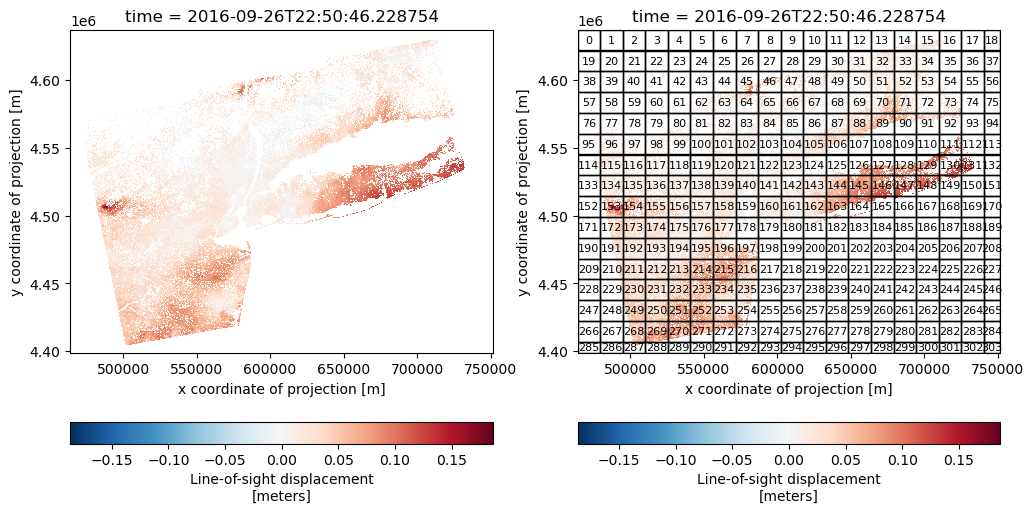

In [11]:
# Plot all chunks, take few min to plot chunk loc
# Skip this step if d
fig, ax = plt.subplots(1,2, figsize=(12,6))
cbar_kwargs={'orientation': 'horizontal'}

disp_epoch1_msk = stack.displacement.isel(time=0).where(stack.recommended_mask.isel(time=0)==1) 

disp_epoch1_msk.plot.imshow(ax=ax[0], cbar_kwargs=cbar_kwargs)
disp_epoch1_msk.plot.imshow(ax=ax[1], cbar_kwargs=cbar_kwargs)
for ix, block in enumerate(chunks_ix):
    plot_chunk_location(ax[1], stack, block, ix, zorder=1)

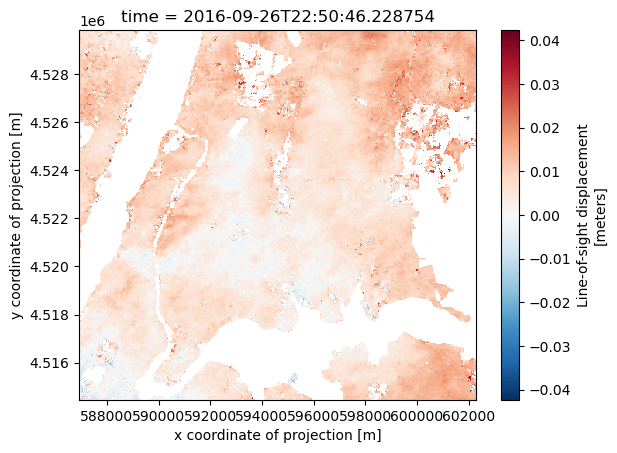

In [13]:
# Plot one chip for dev
ix = 141
mask = stack.recommended_mask[chunks_ix[ix]].isel(time=0)==1
stack.displacement[chunks_ix[ix]].isel(time=0).where(mask).plot.imshow()


In [15]:
small_stack = stack2.isel(y=chunks_ix[ix][1], x=chunks_ix[ix][2])

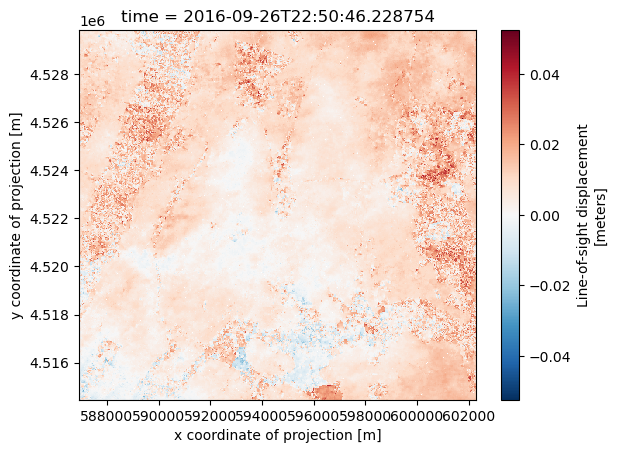

In [17]:
small_stack.displacement.isel(time=0).plot.imshow()

In [22]:
# Get stack quality metrics
pct_ps = quality_metrics.get_ps_percentage(small_stack)
pct_mask = quality_metrics.get_mask_percentage(small_stack) 
pct_conncomp = quality_metrics.get_conncomp_percentage(small_stack, reverse=True)
mean_tcoh = quality_metrics.get_mean_tcoh(small_stack)
mean_psim = quality_metrics.get_mean_phasesim(small_stack)
mean_pcor = quality_metrics.get_mean_phasecorr(small_stack)   

Get percentage of PS


Get percentage of recommended mask
Get percentage of valid connected components
Get mean temporal coherence
Get mean phase similarity
Get mean  estimated_phase_quality


In [27]:
ax.ravel()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

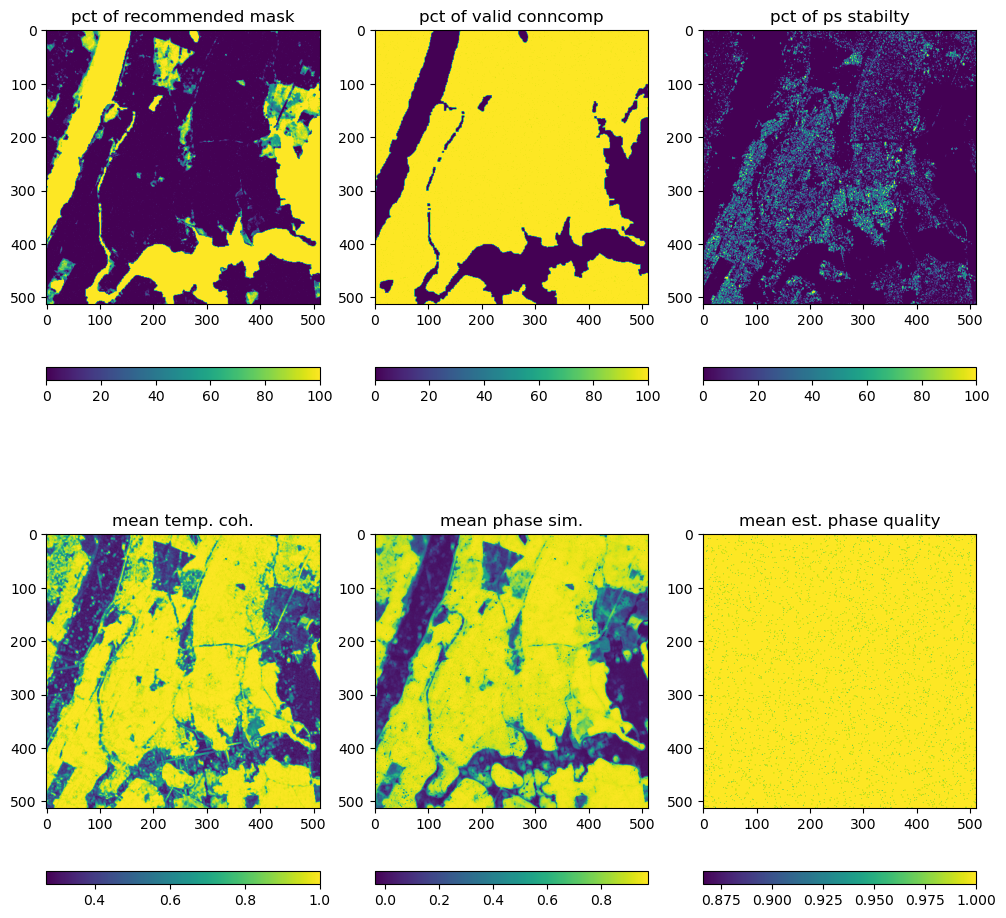

In [32]:
fig, axs = plt.subplots(2,3, figsize=(12,12))

txt = ['pct of recommended mask',
       'pct of valid conncomp',
       'pct of ps stabilty',
       'mean temp. coh.',
       'mean phase sim.',
       'mean est. phase quality']
vars = [pct_mask, pct_conncomp, pct_ps,
        mean_tcoh, mean_psim, mean_pcor]
im =[]
for ix, (t, v, ax) in enumerate(zip(txt, vars, axs.ravel())):
    im.append(ax.imshow(v))
    ax.set_title(t) 

for ax, i in zip(axs.ravel(), im):
    fig.colorbar(i, ax=ax, location='bottom')

In [33]:
# Explore other stats for temporal coherence
tcoh_stats = {}

for mode in ['mean', 'median', 'min', 'max', 'std']:
    tcoh_stats[mode] = quality_metrics.get_mean_tcoh(small_stack, mode)

Get mean temporal coherence


Get median temporal coherence
Get min temporal coherence
Get max temporal coherence
Get std temporal coherence


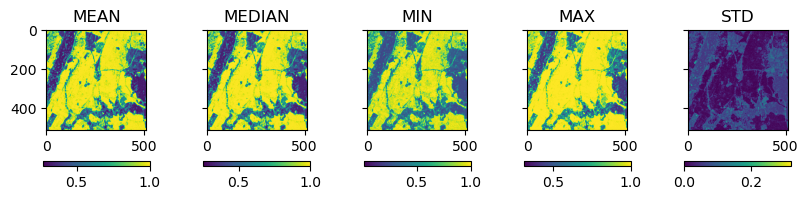

In [43]:
# PLOT
fig, axs = plt.subplots(1,5, figsize=(10,2), sharey=True)

for ax, (tcoh_key, tcoh_value) in zip(axs, tcoh_stats.items()):
    im = (ax.imshow(tcoh_value))
    ax.set_title(tcoh_key.upper())
    fig.colorbar(im, ax=ax, location='bottom', pad=0.2, shrink=0.8)

To run it over full frame, use dask.Client to speed it up

In [ ]:
#